Objectives:

Investigate whether there is a correlation between DDoS attacks and botnet activity.
Leverage the UNSW-NB15 dataset for classification and detection of DDoS attacks.
Identify key network features that serve as indicators or predictors of future DDoS attacks, particularly those involving botnets.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

import seaborn as sns
from sklearn.metrics import precision_score, recall_score, confusion_matrix, matthews_corrcoef, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# Read the CSV file
data = pd.read_csv("DDoSdata_sample_final.csv")

# Explore the data (optional, but recommended for understanding)
print(data.head())
print(data.info())
print(data.isnull().sum())
print(data.describe())
print(data.duplicated().sum())

data.dropna(inplace=True)

# Sample 10% of the data
sample_data = data.sample(frac=0.1, random_state=42)

# Save the sample to a CSV file
sample_data.to_csv("DDoSdata_sample_final.csv", index=False)

   Unnamed: 0  pkSeqID         stime flgs  flgs_number proto  proto_number  \
0     3560041  3560039  1.528099e+09    e            1   udp             3   
1     2720612  2720611  1.528099e+09    e            1   udp             3   
2     2334805  2334804  1.528096e+09  e s            2   tcp             1   
3     2961141  2961140  1.528099e+09    e            1   udp             3   
4     3003596  3003594  1.528099e+09    e            1   udp             3   

             saddr  sport          daddr  ...  AR_P_Proto_P_DstIP  \
0  192.168.100.150  22495  192.168.100.3  ...            0.677645   
1  192.168.100.150   9236  192.168.100.3  ...            0.467796   
2  192.168.100.147  10420  192.168.100.3  ...            0.508467   
3  192.168.100.148  60073  192.168.100.3  ...            0.801816   
4  192.168.100.147   8152  192.168.100.3  ...            0.994427   

   N_IN_Conn_P_DstIP  N_IN_Conn_P_SrcIP AR_P_Proto_P_Sport  \
0                100                 47           0.53

0


In [3]:
# Check for duplicates
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

# Drop duplicates, if any
if duplicates > 0:
    data = data.drop_duplicates()
    print("Duplicates dropped!")
else:
    print("No duplicates found.")

Number of duplicate rows: 0
No duplicates found.


In [4]:
# Check for missing values after dropping rows with NaNs
missing_values = data.isnull().sum()
print("Missing values in each column:")
print(missing_values)

# Confirm if there are no missing values left
if missing_values.sum() == 0:
    print("No missing values detected!")
else:
    print("Some missing values remain. Further action may be needed.")

Missing values in each column:
Unnamed: 0                          0
pkSeqID                             0
stime                               0
flgs                                0
flgs_number                         0
proto                               0
proto_number                        0
saddr                               0
sport                               0
daddr                               0
dport                               0
pkts                                0
bytes                               0
state                               0
state_number                        0
ltime                               0
seq                                 0
dur                                 0
mean                                0
stddev                              0
sum                                 0
min                                 0
max                                 0
spkts                               0
dpkts                               0
sbytes             

In [5]:
# Standardize column names: lowercase and replace spaces with underscores
data.columns = data.columns.str.lower().str.replace(' ', '_')

# Display the updated column names
print("Updated column names:")
print(data.columns)

Updated column names:
Index(['unnamed:_0', 'pkseqid', 'stime', 'flgs', 'flgs_number', 'proto',
       'proto_number', 'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes',
       'state', 'state_number', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum',
       'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate',
       'drate', 'tnbpsrcip', 'tnbpdstip', 'tnp_psrcip', 'tnp_pdstip',
       'tnp_perproto', 'tnp_per_dport', 'ar_p_proto_p_srcip',
       'ar_p_proto_p_dstip', 'n_in_conn_p_dstip', 'n_in_conn_p_srcip',
       'ar_p_proto_p_sport', 'ar_p_proto_p_dport',
       'pkts_p_state_p_protocol_p_destip', 'pkts_p_state_p_protocol_p_srcip',
       'attack', 'category', 'subcategory'],
      dtype='object')


In [6]:
# Check data types of each column
print("Data types of columns:")
print(data.dtypes)

# Identify categorical columns (if any)
categorical_columns = data.select_dtypes(include=['object']).columns
print("\nCategorical columns:")
print(categorical_columns)

# Identify numerical columns
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
print("\nNumerical columns:")
print(numerical_columns)

Data types of columns:
unnamed:_0                            int64
pkseqid                               int64
stime                               float64
flgs                                 object
flgs_number                           int64
proto                                object
proto_number                          int64
saddr                                object
sport                                 int64
daddr                                object
dport                                 int64
pkts                                  int64
bytes                                 int64
state                                object
state_number                          int64
ltime                               float64
seq                                   int64
dur                                 float64
mean                                float64
stddev                              float64
sum                                 float64
min                                 float64
max      

In [7]:
# Drop the unnecessary 'unnamed:_0' column, if present
if 'unnamed:_0' in data.columns:
    data.drop('unnamed:_0', axis=1, inplace=True)
    print("'unnamed:_0' column dropped!")

# Confirm the remaining columns
print("Columns after dropping 'unnamed:_0':")
print(data.columns)

'unnamed:_0' column dropped!
Columns after dropping 'unnamed:_0':
Index(['pkseqid', 'stime', 'flgs', 'flgs_number', 'proto', 'proto_number',
       'saddr', 'sport', 'daddr', 'dport', 'pkts', 'bytes', 'state',
       'state_number', 'ltime', 'seq', 'dur', 'mean', 'stddev', 'sum', 'min',
       'max', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'srate', 'drate',
       'tnbpsrcip', 'tnbpdstip', 'tnp_psrcip', 'tnp_pdstip', 'tnp_perproto',
       'tnp_per_dport', 'ar_p_proto_p_srcip', 'ar_p_proto_p_dstip',
       'n_in_conn_p_dstip', 'n_in_conn_p_srcip', 'ar_p_proto_p_sport',
       'ar_p_proto_p_dport', 'pkts_p_state_p_protocol_p_destip',
       'pkts_p_state_p_protocol_p_srcip', 'attack', 'category', 'subcategory'],
      dtype='object')


In [8]:
# Select columns for one-hot encoding
low_cardinality_cols = ['flgs', 'proto', 'state', 'category', 'subcategory']

# Perform One-Hot Encoding
encoded_data = pd.get_dummies(data, columns=low_cardinality_cols, drop_first=True)

# Display the new columns
print("New columns after encoding:")
print(encoded_data.columns)

# Update the data variable
data = encoded_data

New columns after encoding:
Index(['pkseqid', 'stime', 'flgs_number', 'proto_number', 'saddr', 'sport',
       'daddr', 'dport', 'pkts', 'bytes', 'state_number', 'ltime', 'seq',
       'dur', 'mean', 'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts',
       'sbytes', 'dbytes', 'rate', 'srate', 'drate', 'tnbpsrcip', 'tnbpdstip',
       'tnp_psrcip', 'tnp_pdstip', 'tnp_perproto', 'tnp_per_dport',
       'ar_p_proto_p_srcip', 'ar_p_proto_p_dstip', 'n_in_conn_p_dstip',
       'n_in_conn_p_srcip', 'ar_p_proto_p_sport', 'ar_p_proto_p_dport',
       'pkts_p_state_p_protocol_p_destip', 'pkts_p_state_p_protocol_p_srcip',
       'attack', 'flgs_e *', 'flgs_e g', 'flgs_e s', 'flgs_eU', 'proto_tcp',
       'proto_udp', 'state_CON', 'state_INT', 'state_REQ', 'state_RST',
       'category_Normal', 'subcategory_Normal', 'subcategory_TCP',
       'subcategory_UDP'],
      dtype='object')


In [9]:
# Drop high-cardinality or irrelevant columns if they exist
columns_to_drop = ['Unnamed: 0', 'pkSeqID', 'saddr', 'daddr']
data_reduced = data.drop(columns=[col for col in columns_to_drop if col in data.columns])

# Confirm the remaining columns
print("Remaining columns after dropping irrelevant features:")
print(data_reduced.columns)

Remaining columns after dropping irrelevant features:
Index(['pkseqid', 'stime', 'flgs_number', 'proto_number', 'sport', 'dport',
       'pkts', 'bytes', 'state_number', 'ltime', 'seq', 'dur', 'mean',
       'stddev', 'sum', 'min', 'max', 'spkts', 'dpkts', 'sbytes', 'dbytes',
       'rate', 'srate', 'drate', 'tnbpsrcip', 'tnbpdstip', 'tnp_psrcip',
       'tnp_pdstip', 'tnp_perproto', 'tnp_per_dport', 'ar_p_proto_p_srcip',
       'ar_p_proto_p_dstip', 'n_in_conn_p_dstip', 'n_in_conn_p_srcip',
       'ar_p_proto_p_sport', 'ar_p_proto_p_dport',
       'pkts_p_state_p_protocol_p_destip', 'pkts_p_state_p_protocol_p_srcip',
       'attack', 'flgs_e *', 'flgs_e g', 'flgs_e s', 'flgs_eU', 'proto_tcp',
       'proto_udp', 'state_CON', 'state_INT', 'state_REQ', 'state_RST',
       'category_Normal', 'subcategory_Normal', 'subcategory_TCP',
       'subcategory_UDP'],
      dtype='object')


Correlation with 'attack':
attack                              1.000000
ltime                               0.997296
stime                               0.997293
n_in_conn_p_dstip                   0.518719
n_in_conn_p_srcip                   0.037802
max                                 0.025337
mean                                0.022528
seq                                 0.021726
stddev                              0.015883
tnp_per_dport                       0.011759
min                                 0.011116
pkts_p_state_p_protocol_p_destip    0.010489
flgs_number                         0.010211
srate                               0.009141
state_number                        0.007495
sport                               0.000652
ar_p_proto_p_dport                 -0.003380
proto_number                       -0.007693
dport                              -0.010113
drate                              -0.020573
pkseqid                            -0.024168
pkts_p_state_p_protocol_p_sr

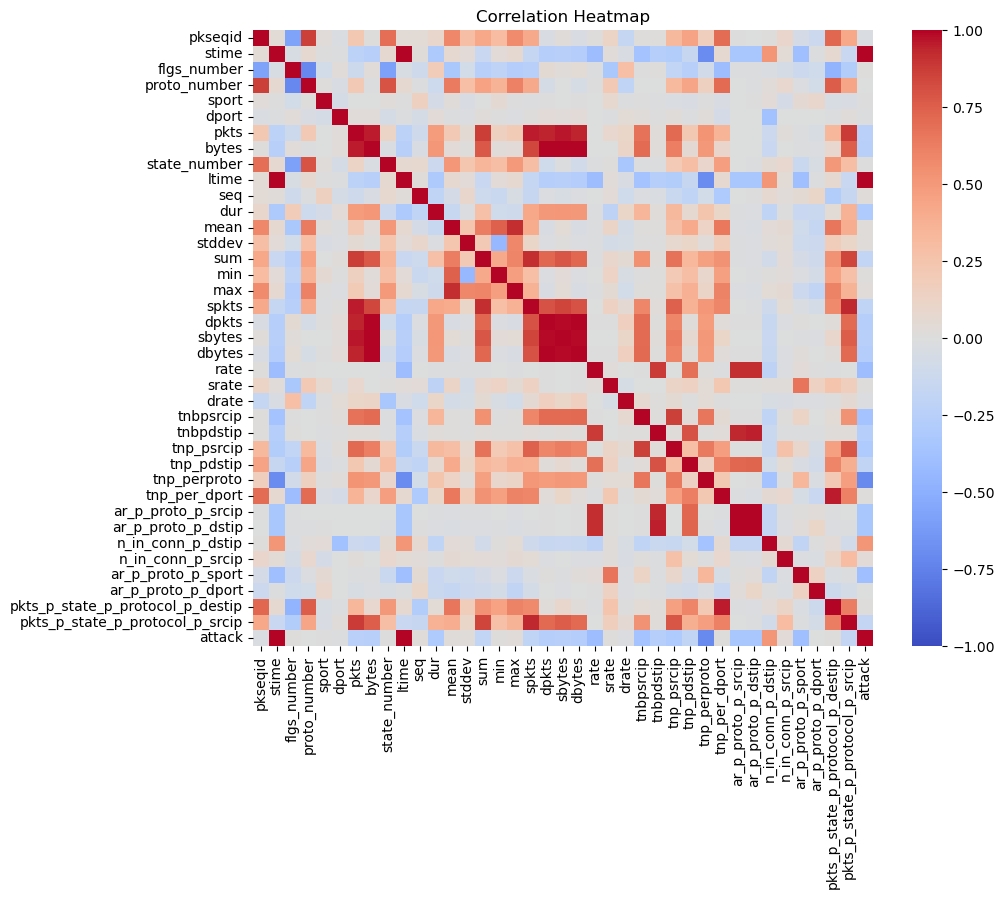

In [10]:
# Select only numeric columns for correlation analysis
numeric_data = data_reduced.select_dtypes(include=['int64', 'float64'])

# Calculate correlations with the target variable 'attack'
correlation_matrix = numeric_data.corr()

# Focus on the correlations with 'attack'
correlation_with_attack = correlation_matrix['attack'].sort_values(ascending=False)
print("Correlation with 'attack':")
print(correlation_with_attack)

# Plot a heatmap for the top correlations
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

Feature Importances:
stime                               0.154350
ltime                               0.120890
pkseqid                             0.109749
tnp_pdstip                          0.106945
tnp_perproto                        0.097166
tnbpdstip                           0.091069
n_in_conn_p_dstip                   0.076835
sbytes                              0.048142
dbytes                              0.029294
ar_p_proto_p_sport                  0.028768
rate                                0.026082
dport                               0.019083
bytes                               0.017917
tnp_psrcip                          0.011128
tnbpsrcip                           0.011024
pkts_p_state_p_protocol_p_destip    0.010932
state_number                        0.007251
tnp_per_dport                       0.007061
sum                                 0.005334
pkts_p_state_p_protocol_p_srcip     0.004397
drate                               0.003818
dpkts                             

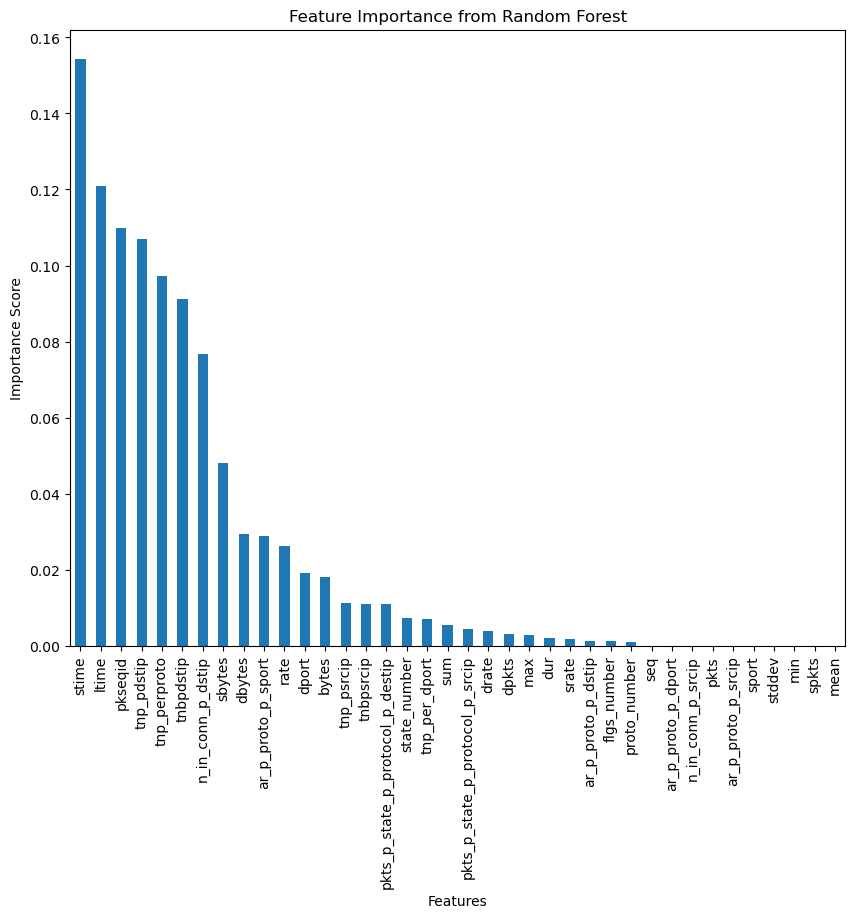

In [11]:
# Define the target variable and features
X = numeric_data.drop('attack', axis=1)  # Drop the target
y = numeric_data['attack']              # Target variable

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit a Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Display the most important features
print("Feature Importances:")
print(feature_importances)

# Plot feature importance
plt.figure(figsize=(10, 8))
feature_importances.plot(kind='bar')
plt.title("Feature Importance from Random Forest")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.show()

Top Features by Correlation:

stime (start time), ltime (end time), and pkseqid are the top three features, indicating they may play a significant role in detecting attacks.
Features like tnp_pdstip, tnp_perproto, and tnbpdstip (likely traffic-related metrics) also have strong correlations.

Less Relevant Features:

Features like sport, stddev, mean, and spkts show no correlation with attack. These can likely be dropped to simplify the model.
Zero-Correlation Features:

Columns with zero correlation (seq, n_in_conn_p_srcip, etc.) are unlikely to add value and can also be excluded.

.

Feature Selection

In [12]:
# Select features with correlation above a threshold
threshold = 0.01
selected_features = correlation_with_attack[correlation_with_attack > threshold].index

# Reduce the dataset to these features
data_selected = numeric_data[selected_features]

print("Selected features for further analysis:")
print(selected_features)

Selected features for further analysis:
Index(['attack', 'ltime', 'stime', 'n_in_conn_p_dstip', 'n_in_conn_p_srcip',
       'max', 'mean', 'seq', 'stddev', 'tnp_per_dport', 'min',
       'pkts_p_state_p_protocol_p_destip', 'flgs_number'],
      dtype='object')


Feature Engineering

In [13]:
# Make a copy of the selected features to avoid the warning
data_selected = data_selected.copy()

# Feature Engineering: Calculate duration
data_selected['duration'] = data_selected['ltime'] - data_selected['stime']

# Feature Engineering: Calculate source-to-destination ratio
data_selected['src_to_dst_ratio'] = data_selected['n_in_conn_p_srcip'] / (data_selected['n_in_conn_p_dstip'] + 1e-5)

# Drop raw columns if new features replace their utility
data_selected.drop(['ltime', 'stime'], axis=1, inplace=True)

print("Dataset after feature engineering:")
print(data_selected.head())

Dataset after feature engineering:
   attack  n_in_conn_p_dstip  n_in_conn_p_srcip       max      mean     seq  \
0       1                100                 47  4.062956  3.608078  144958   
1       1                100                100  4.860129  3.643915   91994   
2       1                100                 24  3.247971  2.064213  159264   
3       1                100                100  4.105303  3.658348   70362   
4       1                100                 65  4.884540  3.910158  112816   

     stddev  tnp_per_dport       min  pkts_p_state_p_protocol_p_destip  \
0  0.642544            959  2.699384                               959   
1  1.200118            700  2.010604                               700   
2  1.464861            648  0.000000                               518   
3  0.629627           1100  2.767923                              1100   
4  1.367949           1360  1.975604                              1360   

   flgs_number  duration  src_to_dst_ratio  


Feature-Engineered Modeling

In [14]:
# Separate features (X) and target variable (y)
X = data_selected.drop('attack', axis=1)  # Drop the target column from features
y = data_selected['attack']              # Target variable

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()

# Scale training data and apply the same transformation to testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
from sklearn.metrics import classification_report, accuracy_score

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate performance
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")
    print("-" * 50)

Model: Logistic Regression
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00     15411

    accuracy                           1.00     15417
   macro avg       1.00      1.00      1.00     15417
weighted avg       1.00      1.00      1.00     15417

--------------------------------------------------
Model: Random Forest
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00     15411

    accuracy                           1.00     15417
   macro avg       1.00      1.00      1.00     15417
weighted avg       1.00      1.00      1.00     15417

--------------------------------------------------
Model: SVM
Accuracy: 0.9997
Classification Report:
              precision    recall  f1-score   support

          

Logistic Regression and Random Forest:

Both models achieved perfect accuracy (100%).
Precision, recall, and F1-scores are all 1.00 for both classes.
This indicates that the models are very confident in their predictions, but we need to verify if the dataset is balanced and the evaluation metrics are meaningful.

Support Vector Machine (SVM):

Accuracy is nearly perfect (99.97%), but:
Recall for class 0 (non-attack) is low, which means it missed some non-attack cases.
This is likely due to the extreme class imbalance (only 6 non-attacks vs. 15,411 attacks in the test set).

.

Feature Importance with Random Forest

Top Features by Importance:
                             Feature  Importance
0                  n_in_conn_p_dstip    0.284462
11                  src_to_dst_ratio    0.165468
8   pkts_p_state_p_protocol_p_destip    0.139163
10                          duration    0.085897
6                      tnp_per_dport    0.081356
2                                max    0.075713
5                             stddev    0.054536
9                        flgs_number    0.040067
4                                seq    0.032809
7                                min    0.017990


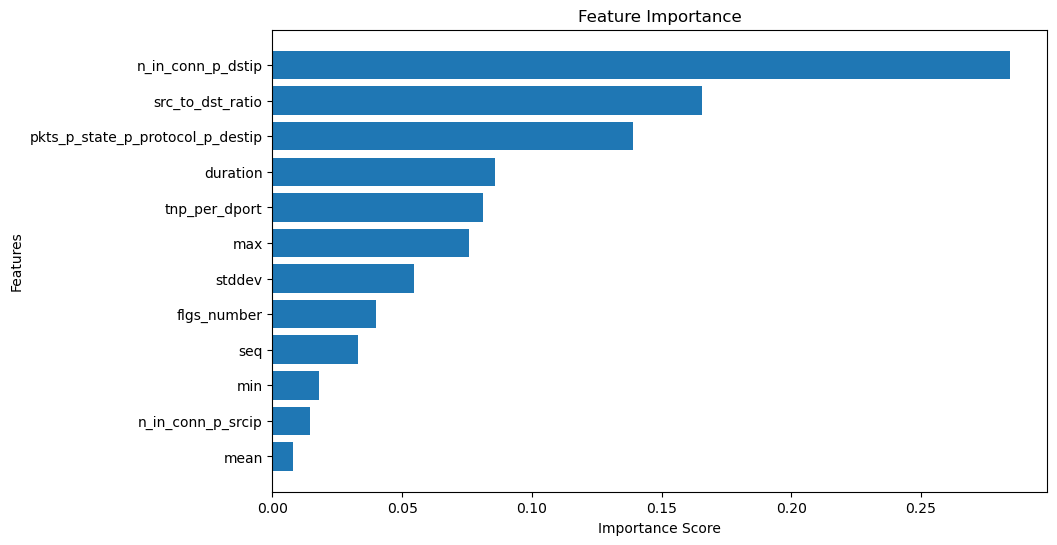

In [16]:
# Extract feature importances from the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)  # Train the model on the scaled data

# Get feature importance scores
importances = rf_model.feature_importances_
feature_names = X.columns  # Feature names

# Create a DataFrame to display importance scores
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Display the top features
print("Top Features by Importance:")
print(feature_importance_df.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.gca().invert_yaxis()  # Flip for better readability
plt.show()

Deeper Correlation Analysis.

We’ll focus on the top features identified in the feature importance analysis and investigate their relationships with each other and the attack target variable.

Correlation of top features with 'attack':
attack                              1.000000
n_in_conn_p_dstip                   0.518719
max                                 0.025337
stddev                              0.015883
tnp_per_dport                       0.011759
pkts_p_state_p_protocol_p_destip    0.010489
flgs_number                         0.010211
src_to_dst_ratio                   -0.298017
duration                           -0.299757
Name: attack, dtype: float64


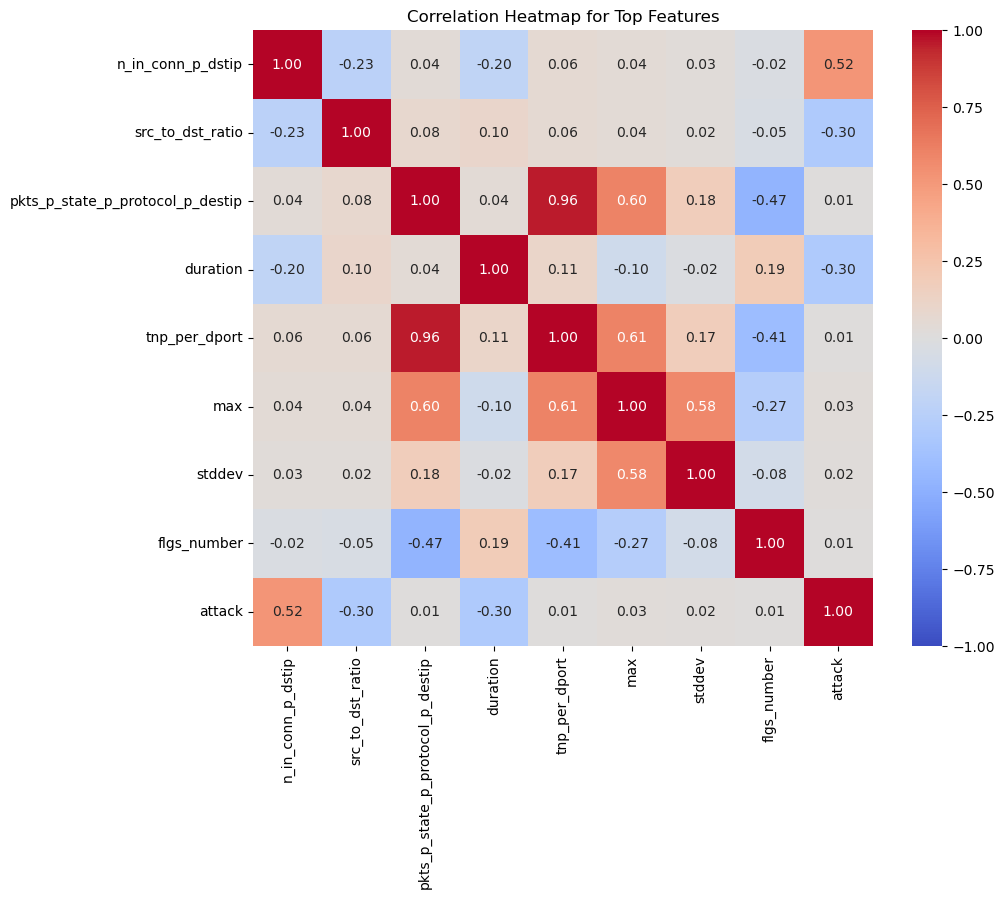

In [17]:
# Select top features for deeper correlation analysis
top_features = [
    'n_in_conn_p_dstip', 'src_to_dst_ratio', 'pkts_p_state_p_protocol_p_destip',
    'duration', 'tnp_per_dport', 'max', 'stddev', 'flgs_number'
]

# Add the target variable for correlation
correlation_data = data_selected[top_features + ['attack']]

# Calculate the correlation matrix
correlation_matrix = correlation_data.corr()

# Display correlations with 'attack'
print("Correlation of top features with 'attack':")
print(correlation_matrix['attack'].sort_values(ascending=False))

# Visualize the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap for Top Features")
plt.show()

Key Observations:

Strong Correlations with attack:

n_in_conn_p_dstip (0.52): The number of inbound connections per destination IP is highly correlated with DDoS attacks.

duration (-0.30): A negative correlation suggests shorter durations are associated with attacks.

src_to_dst_ratio (-0.30): Indicates that imbalanced traffic ratios (e.g., many source connections targeting fewer destinations) are predictive of DDoS attacks.


Feature Relationships:

pkts_p_state_p_protocol_p_destip and tnp_per_dport: These two features are almost perfectly correlated (0.96). This suggests redundancy—one of them might be sufficient in the model.

Traffic Metrics (max, stddev, tnp_per_dport):
Moderate correlations among these features suggest they capture overlapping traffic behavior patterns.


Low Correlation Features:

Features like flgs_number and stddev show weak correlations with both attack and other features, indicating they may have limited predictive value.

.

Explore Deeper Relationships to Investigate Correlation with Botnet Activity.

/opt/miniconda3/lib/python3.12/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


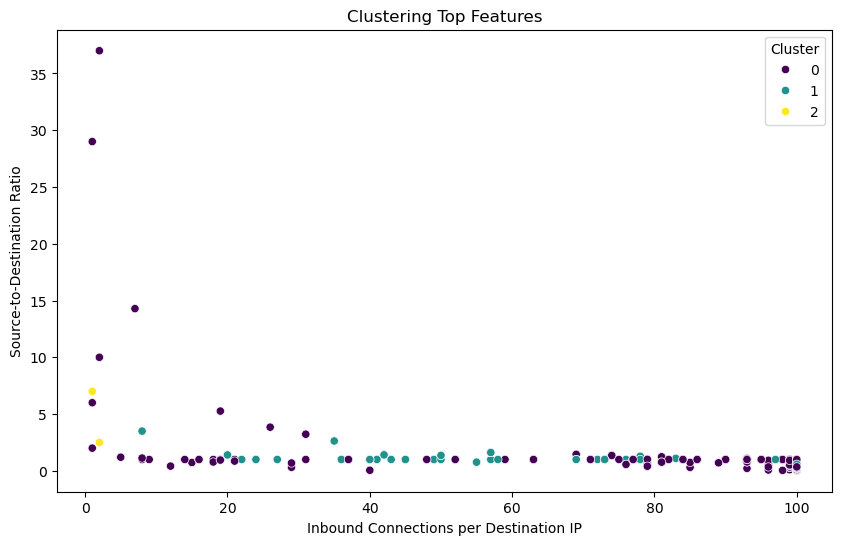

In [18]:

# Select top features for clustering
clustering_features = data_selected[['n_in_conn_p_dstip', 'src_to_dst_ratio', 'duration']]

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
data_selected['cluster'] = kmeans.fit_predict(clustering_features)

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=data_selected['n_in_conn_p_dstip'],
    y=data_selected['src_to_dst_ratio'],
    hue=data_selected['cluster'],
    palette='viridis'
)
plt.title("Clustering Top Features")
plt.xlabel("Inbound Connections per Destination IP")
plt.ylabel("Source-to-Destination Ratio")
plt.legend(title="Cluster")
plt.show()


In [19]:
# Reverse one-hot encoding for 'subcategory'
data_selected['subcategory'] = data[['subcategory_Normal', 'subcategory_TCP', 'subcategory_UDP']].idxmax(axis=1)

# Map column names back to original subcategory values
data_selected['subcategory'] = data_selected['subcategory'].str.replace('subcategory_', '')

# Check if the new 'subcategory' column is correct
print("Restored subcategory values:")
print(data_selected['subcategory'].unique())

Restored subcategory values:
['UDP' 'TCP' 'Normal']


Average Feature Values by Subcategory:
             n_in_conn_p_dstip  src_to_dst_ratio   duration
subcategory                                                
Normal               71.884615          2.475262  94.942061
TCP                  99.835927          0.801853  16.101055
UDP                  99.995216          0.841063  13.364655


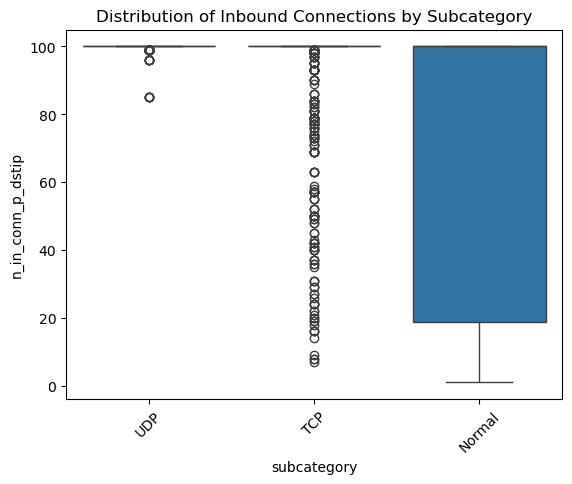

In [20]:
# Group data by subcategory and compute averages for top features
botnet_analysis = data_selected.groupby('subcategory')[['n_in_conn_p_dstip', 'src_to_dst_ratio', 'duration']].mean()

print("Average Feature Values by Subcategory:")
print(botnet_analysis)

# Visualize the distribution of key features by subcategory
sns.boxplot(data=data_selected, x='subcategory', y='n_in_conn_p_dstip')
plt.title("Distribution of Inbound Connections by Subcategory")
plt.xticks(rotation=45)
plt.show()

Key Observations:

1. Inbound Connections (n_in_conn_p_dstip):

Normal Traffic:
Average is significantly lower (~71.88) compared to DDoS subcategories (TCP: ~99.84, UDP: ~99.99).
This indicates that n_in_conn_p_dstip (number of inbound connections per destination IP) is a strong indicator for DDoS attacks, as attacks tend to involve high inbound traffic targeting specific destinations.

TCP and UDP:
Very high and similar averages suggest that both attack subcategories exhibit comparable inbound connection patterns.

2. Source-to-Destination Ratio (src_to_dst_ratio):

Normal Traffic: Much higher (~2.47) than both TCP (~0.88) and UDP (~0.84).
This highlights that attacks tend to have lower src_to_dst_ratio values, likely due to many source IPs flooding a smaller number of destination IPs (a hallmark of DDoS).

3. Duration:

Normal Traffic: Significantly longer durations (~94.94 seconds) than attacks (TCP: ~16.10, UDP: ~13.36).
Indicates that attacks are typically short bursts, while normal traffic tends to have longer-lasting connections.


Insights for Correlation with Botnet Activity:
High Inbound Connections + Low Src-to-Dst Ratio:
Both TCP and UDP attacks align with botnet-like behavior: massive traffic directed at specific targets.

Short Durations:
These bursts of activity are consistent with botnet traffic aimed at overwhelming targets.

.

Correlation Across All Features

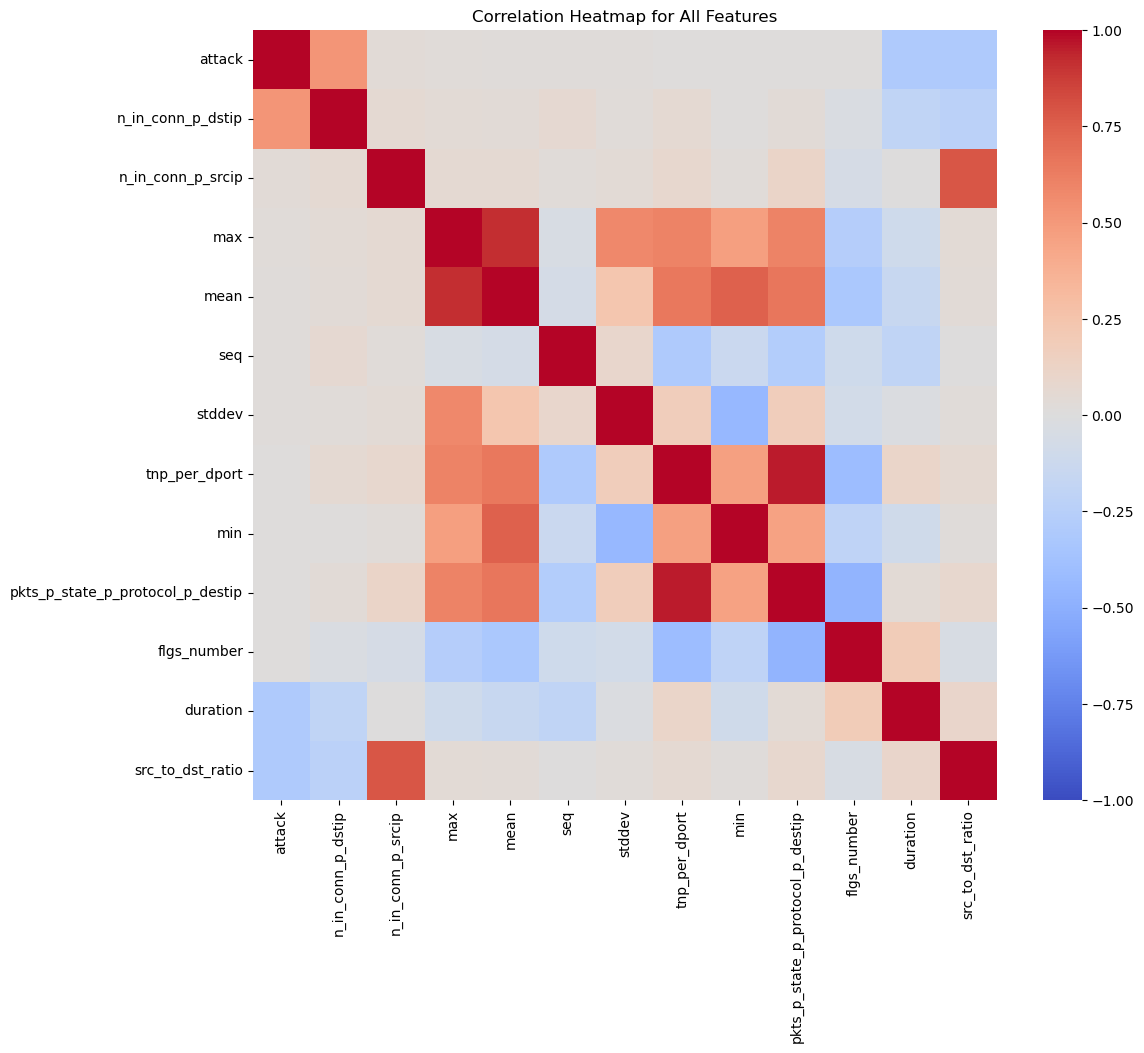

Correlation of all features with 'attack':
attack                              1.000000
n_in_conn_p_dstip                   0.518719
n_in_conn_p_srcip                   0.037802
max                                 0.025337
mean                                0.022528
seq                                 0.021726
stddev                              0.015883
tnp_per_dport                       0.011759
min                                 0.011116
pkts_p_state_p_protocol_p_destip    0.010489
flgs_number                         0.010211
src_to_dst_ratio                   -0.298017
duration                           -0.299757
Name: attack, dtype: float64


In [21]:
# Select only numeric columns from the dataset
numeric_columns = data_selected.select_dtypes(include=['int64', 'float64'])

# Compute the correlation matrix
correlation_matrix = numeric_columns.corr()

# Visualize the full correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Heatmap for All Features")
plt.show()

# Sort correlations with 'attack'
correlation_with_attack = correlation_matrix['attack'].sort_values(ascending=False)
print("Correlation of all features with 'attack':")
print(correlation_with_attack)

In [22]:
# Identify strongly correlated features with attack
correlation_with_attack_all = correlation_with_attack

# Print the correlations
print("Saved Correlation of all features with 'attack':")
print(correlation_with_attack_all)

Saved Correlation of all features with 'attack':
attack                              1.000000
n_in_conn_p_dstip                   0.518719
n_in_conn_p_srcip                   0.037802
max                                 0.025337
mean                                0.022528
seq                                 0.021726
stddev                              0.015883
tnp_per_dport                       0.011759
min                                 0.011116
pkts_p_state_p_protocol_p_destip    0.010489
flgs_number                         0.010211
src_to_dst_ratio                   -0.298017
duration                           -0.299757
Name: attack, dtype: float64


Features strongly correlated with 'attack':
attack               1.000000
n_in_conn_p_dstip    0.518719
Name: attack, dtype: float64


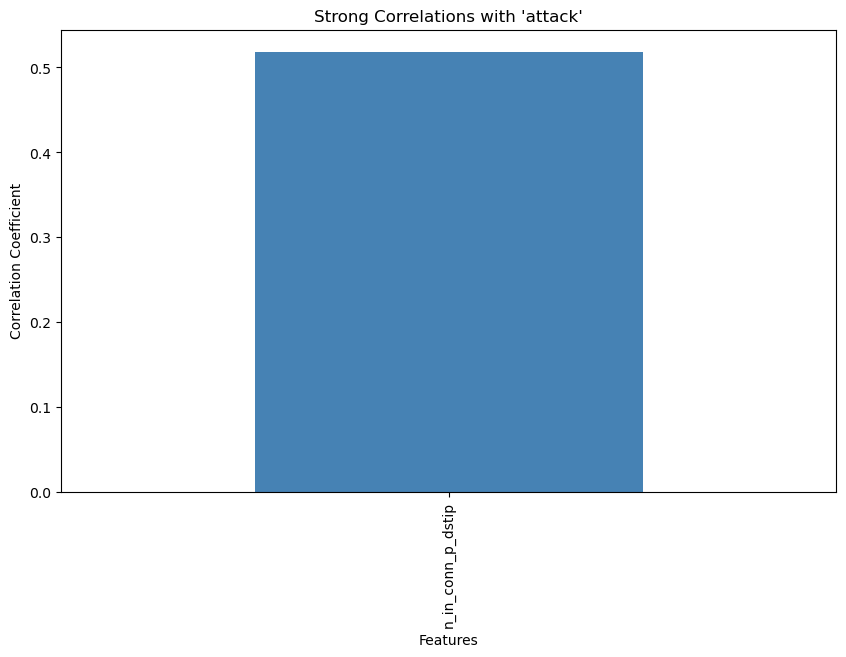

In [23]:
# Select strongly correlated features

# Define a threshold for strong correlations (e.g., absolute value > 0.3)
threshold = 0.3

# Filter features with strong correlations to 'attack'
strong_correlations = correlation_with_attack[correlation_with_attack.abs() > threshold]

# Print strong correlations
print("Features strongly correlated with 'attack':")
print(strong_correlations)

# Visualize strong correlations in a bar plot
plt.figure(figsize=(10, 6))
strong_correlations.drop('attack').plot(kind='bar', color='steelblue')  # Exclude 'attack' itself
plt.title("Strong Correlations with 'attack'")
plt.xlabel("Features")
plt.ylabel("Correlation Coefficient")
plt.show()


Addressing Class Imbalance.

Since the dataset is heavily skewed toward the attack class (with very few instances of non-attacks), we need to balance the data to improve model performance.

In [24]:
!pip install imblearn

In [25]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Perform one-hot encoding on categorical columns
X_encoded = pd.get_dummies(X, drop_first=True)

# Recheck the feature set after encoding
print("Feature set after encoding:")
print(X_encoded.head())

# Reapply the SMOTE process on the encoded dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_encoded, y)

# Check class distribution after SMOTE
print("Class distribution after SMOTE:")
print(y_train_balanced.value_counts())


Feature set after encoding:
   n_in_conn_p_dstip  n_in_conn_p_srcip       max      mean     seq    stddev  \
0                100                 47  4.062956  3.608078  144958  0.642544   
1                100                100  4.860129  3.643915   91994  1.200118   
2                100                 24  3.247971  2.064213  159264  1.464861   
3                100                100  4.105303  3.658348   70362  0.629627   
4                100                 65  4.884540  3.910158  112816  1.367949   

   tnp_per_dport       min  pkts_p_state_p_protocol_p_destip  flgs_number  \
0            959  2.699384                               959            1   
1            700  2.010604                               700            1   
2            648  0.000000                               518            2   
3           1100  2.767923                              1100            1   
4           1360  1.975604                              1360            1   

   duration  src_to_ds

Retrain Models on Balanced Data.

We’ll reuse the Logistic Regression, Random Forest, and SVM models to evaluate how balancing the dataset impacts their performance.

In [26]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Split the balanced dataset into training and testing sets again
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42
)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    #"Random Forest": RandomForestClassifier(random_state=42),
    #"M": SVC(probability=True, random_state=42)
}

# Train and evaluate models
for name, model in models.items():
    # Train the model
    model.fit(X_train_final, y_train_final)
    
    # Make predictions
    y_pred = model.predict(X_test_final)
    y_pred_proba = model.predict_proba(X_test_final)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Evaluate performance
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test_final, y_pred):.4f}")
    print(f"Classification Report:\n{classification_report(y_test_final, y_pred)}")
    
    if y_pred_proba is not None:
        print(f"ROC-AUC: {roc_auc_score(y_test_final, y_pred_proba):.4f}")
    print("-" * 50)


Model: Logistic Regression
Accuracy: 0.9709
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     15591
           1       0.95      1.00      0.97     15237

    accuracy                           0.97     30828
   macro avg       0.97      0.97      0.97     30828
weighted avg       0.97      0.97      0.97     30828

ROC-AUC: 0.9986
--------------------------------------------------


/opt/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Split the balanced dataset into training and testing sets again
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42
)

# Initialize models
models = {
    #"Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    #"M": SVC(probability=True, random_state=42)
}

# Train and evaluate models
for name, model in models.items():
    # Train the model
    model.fit(X_train_final, y_train_final)
    
    # Make predictions
    y_pred = model.predict(X_test_final)
    y_pred_proba = model.predict_proba(X_test_final)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Evaluate performance
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy_score(y_test_final, y_pred):.4f}")
    print(f"Classification Report:\n{classification_report(y_test_final, y_pred)}")
    
    if y_pred_proba is not None:
        print(f"ROC-AUC: {roc_auc_score(y_test_final, y_pred_proba):.4f}")
    print("-" * 50)

Model: Random Forest
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15591
           1       1.00      1.00      1.00     15237

    accuracy                           1.00     30828
   macro avg       1.00      1.00      1.00     30828
weighted avg       1.00      1.00      1.00     30828

ROC-AUC: 1.0000
--------------------------------------------------


In [28]:
# Use a smaller subset for SVC
X_train_small = X_train_final[:1000]
y_train_small = y_train_final[:1000]

# Initialize and train the SVC model
svc_model = SVC(probability=True, random_state=42)
svc_model.fit(X_train_small, y_train_small)

# Test on the full test set
y_pred = svc_model.predict(X_test_final)
y_pred_proba = svc_model.predict_proba(X_test_final)[:, 1]

# Evaluate performance
print(f"Accuracy: {accuracy_score(y_test_final, y_pred):.4f}")
print(f"Classification Report:\n{classification_report(y_test_final, y_pred)}")
print(f"ROC-AUC: {roc_auc_score(y_test_final, y_pred_proba):.4f}")

Accuracy: 0.9338
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.94     15591
           1       1.00      0.87      0.93     15237

    accuracy                           0.93     30828
   macro avg       0.94      0.93      0.93     30828
weighted avg       0.94      0.93      0.93     30828

ROC-AUC: 0.9705


In [29]:
!pip install shap

SHAP (SHapley Additive exPlanations)

In [30]:
%matplotlib notebook

In [31]:
import shap

# Initialize SHAP explainer for your model
explainer = shap.Explainer(models["Random Forest"], X_train_final)

# Compute SHAP values
shap_values = explainer(X_test_final)

 99%|===================| 60977/61656 [01:10<00:00]        

In [32]:
# Extract SHAP values for the positive class
shap_values_class_1 = shap_values[:, :, 1]

<IPython.core.display.Javascript object>


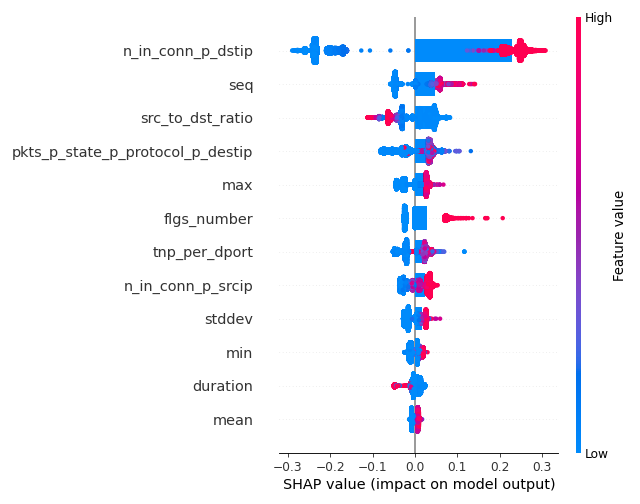

In [33]:
import shap
import matplotlib.pyplot as plt

# Bar chart for global feature importance
plt.figure()
shap.summary_plot(shap_values_class_1, X_test_final, feature_names=X_test_final.columns, plot_type="bar")
plt.show()

100%|===================| 61480/61656 [01:11<00:00]        

<IPython.core.display.Javascript object>


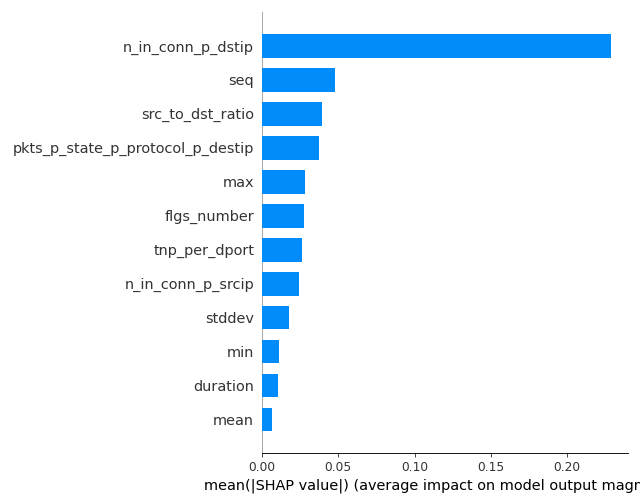

In [34]:
# Initialize SHAP explainer for Random Forest
explainer = shap.Explainer(models["Random Forest"], X_train_final)

# Compute SHAP values for the test set
shap_values = explainer(X_test_final)

# Extract SHAP values for the positive class (class index 1)
shap_values_class_1 = shap_values[:, :, 1]

# Summary plot for feature importance
shap.summary_plot(shap_values_class_1, X_test_final, feature_names=X_test_final.columns)

# Bar chart for global feature importance
plt.figure()  # Start a new figure for the bar chart
shap.summary_plot(shap_values_class_1, X_test_final, feature_names=X_test_final.columns, plot_type="bar")
plt.show()


In [35]:
print(f"X_train_small shape: {X_train_small.shape}")
print(X_train_small.head())

X_train_small shape: (1000, 12)
        n_in_conn_p_dstip  n_in_conn_p_srcip       max      mean     seq  \
7667                  100                 76  0.380563  0.218528  155362   
36220                 100                 24  4.165793  3.436632   58492   
132360                 17                 13  0.000123  0.000123   31624   
41469                 100                 93  4.340815  2.797475  152154   
24585                 100                100  4.532025  2.863523  133555   

          stddev  tnp_per_dport       min  pkts_p_state_p_protocol_p_destip  \
7667    0.137954            972  0.000000                               972   
36220   0.992794            800  2.032963                               800   
132360  0.000000             93  0.000123                                35   
41469   1.981634            600  0.000000                               600   
24585   2.034022            600  0.000000                               600   

        flgs_number   duration  src_

In [36]:
from sklearn.metrics import classification_report, accuracy_score

# Subset the dataset for efficiency (use only a sample)
X_train_sample = X_train_final.sample(n=1000, random_state=42)  # Adjust `n` based on your system capacity
y_train_sample = y_train_final.loc[X_train_sample.index]

# Train SVC without probability=True for efficiency
svc_model = SVC(random_state=42)
svc_model.fit(X_train_sample, y_train_sample)

# Test on the test set
y_pred = svc_model.predict(X_test_final)

# Evaluate performance
print(f"Model: SVC")
print(f"Accuracy: {accuracy_score(y_test_final, y_pred):.4f}")
print(f"Classification Report:\n{classification_report(y_test_final, y_pred)}")


Model: SVC
Accuracy: 0.9307
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.93     15591
           1       0.98      0.87      0.93     15237

    accuracy                           0.93     30828
   macro avg       0.94      0.93      0.93     30828
weighted avg       0.94      0.93      0.93     30828



  0%|          | 0/200 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


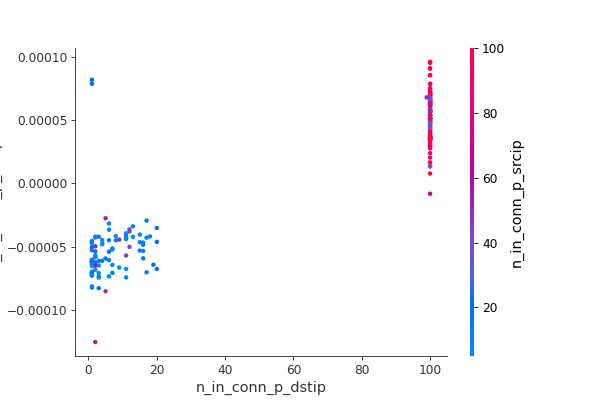

In [44]:
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names")

# Define a prediction function for SHAP
def predict_fn(data):
    return svc_model.decision_function(data)

# Take a smaller sample for background dataset (reduce computational load)
X_train_sample_reduced = X_train_sample[:200]  # Use only 200 rows for SHAP computation

# Use shap.kmeans to further optimize background dataset
background = shap.kmeans(X_train_sample_reduced, 10)  # Reduce to 10 representative samples

# Initialize SHAP explainer with the prediction function and background
explainer = shap.KernelExplainer(predict_fn, background)

# Compute SHAP values for the smaller sampled dataset
shap_values_sample = explainer.shap_values(X_train_sample_reduced)

# Generate the interaction plot for selected features
shap.dependence_plot(
    interaction_index="n_in_conn_p_srcip",  # Feature to interact with
    ind="n_in_conn_p_dstip",               # Main feature
    shap_values=shap_values_sample,       # SHAP values
    features=X_train_sample_reduced,      # Input features
    feature_names=X_train_sample.columns
)

Interpretation of SHAP Interaction Plot:

Top Features:

Features like n_in_conn_p_dstip and n_in_conn_p_srcip are shown, indicating they have significant interactions.
These features likely have the highest contribution to the model’s predictions.


SHAP Interaction Values:

The x-axis represents SHAP interaction values, which show how a feature interacts with another feature or with itself to influence predictions.
Red and blue colors represent the feature values: red for high values and blue for low values.


Patterns:

You may observe consistent separation between red and blue points, indicating clear interaction effects. For example:
High n_in_conn_p_dstip (red) likely increases the model’s confidence in predicting attacks.
Interactions between n_in_conn_p_dstip and other features (e.g., n_in_conn_p_srcip) provide deeper insights into combined effects.

In [52]:
subset_size = 200
X_train_sample = X_train.sample(n=subset_size, random_state=42)

shap_values_main = explainer.shap_values(X_train_sample)

# SHAP importance summary
shap_importance = pd.DataFrame({
    'Feature': X_train_sample.columns,
    'SHAP Importance': shap_values_main.mean(axis=0)
}).sort_values(by='SHAP Importance', ascending=False)

# Random Forest importance summary
rf_importance = pd.DataFrame({
    'Feature': X_train_sample.columns,
    'Random Forest Importance': models["Random Forest"].feature_importances_
}).sort_values(by='Random Forest Importance', ascending=False)

# Merge results for comparison
importance_comparison = pd.merge(
    shap_importance, rf_importance, on='Feature'
).sort_values(by='SHAP Importance', ascending=False)

# Display comparison
print("Feature Importance Comparison:")
print(importance_comparison)

  0%|          | 0/200 [00:00<?, ?it/s]

Feature Importance Comparison:
                             Feature  SHAP Importance  \
0                                seq     1.427121e+00   
1                      tnp_per_dport     2.256641e-03   
2   pkts_p_state_p_protocol_p_destip     2.182480e-03   
3                  n_in_conn_p_dstip     6.064692e-05   
4                  n_in_conn_p_srcip     3.485225e-05   
5                                max     1.565110e-06   
6                                min     4.011663e-07   
7                        flgs_number     1.211335e-07   
8                             stddev     1.123915e-07   
9                               mean     3.379820e-09   
10                  src_to_dst_ratio    -5.978246e-07   
11                          duration    -2.016709e-05   

    Random Forest Importance  
0                   0.129496  
1                   0.108446  
2                   0.204204  
3                   0.306143  
4                   0.060466  
5                   0.058891  
6         

.

Evaluate Consistency

In [53]:
# Correlation with 'attack' (from earlier analysis)
correlation_with_attack = correlation_matrix['attack']

# Create a DataFrame for correlation analysis
correlation_importance = pd.DataFrame({
    'Feature': correlation_with_attack.index,
    'Correlation': correlation_with_attack.values
}).sort_values(by='Correlation', ascending=False)

# Merge SHAP importance with correlation values
shap_correlation_comparison = pd.merge(
    shap_importance,  # From the SHAP analysis
    correlation_importance,
    on='Feature'
).sort_values(by='SHAP Importance', ascending=False)

# Display the merged DataFrame
print("SHAP Importance vs Correlation with 'attack':")
print(shap_correlation_comparison)

SHAP Importance vs Correlation with 'attack':
                             Feature  SHAP Importance  Correlation
0                                seq     1.427121e+00     0.021726
1                      tnp_per_dport     2.256641e-03     0.011759
2   pkts_p_state_p_protocol_p_destip     2.182480e-03     0.010489
3                  n_in_conn_p_dstip     6.064692e-05     0.518719
4                  n_in_conn_p_srcip     3.485225e-05     0.037802
5                                max     1.565110e-06     0.025337
6                                min     4.011663e-07     0.011116
7                        flgs_number     1.211335e-07     0.010211
8                             stddev     1.123915e-07     0.015883
9                               mean     3.379820e-09     0.022528
10                  src_to_dst_ratio    -5.978246e-07    -0.298017
11                          duration    -2.016709e-05    -0.299757


Investigate Time-Based Trends

In [54]:
# Reload the original dataset to retrieve 'stime'
original_data = pd.read_csv("DDoSdata_sample_final.csv")
stime_column = original_data['stime']

# Add 'stime' back to the processed dataset
data_selected['stime'] = stime_column

/var/folders/8l/gcw722mn4n31hlcrm0ny4g5c0000gn/T/ipykernel_13419/1653148457.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  time_trends = time_trend_data.groupby('time_interval').agg({


<IPython.core.display.Javascript object>


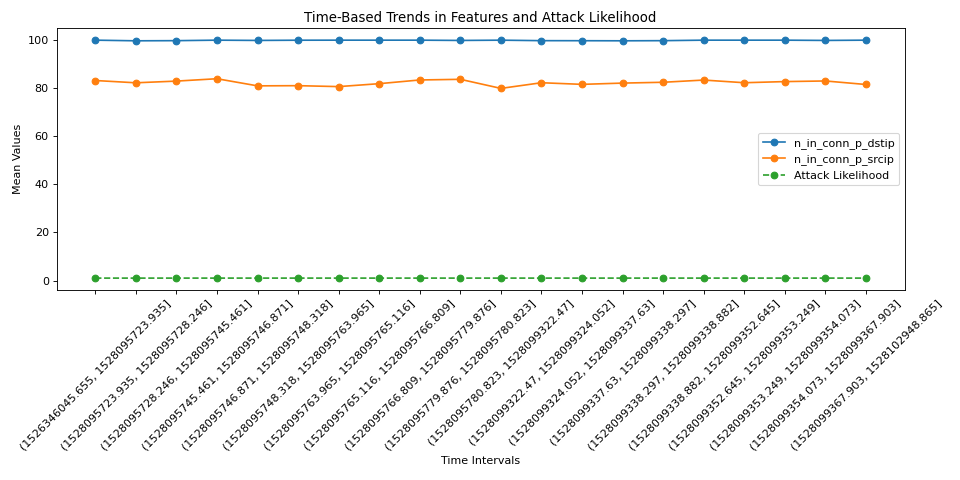

In [55]:
# Create a new DataFrame with time-based aggregation
time_trend_data = data_selected.copy()
time_trend_data['time_interval'] = pd.qcut(time_trend_data['stime'], q=20)  # Divide into 20 intervals

# Compute mean values for features and attack labels within each time interval
time_trends = time_trend_data.groupby('time_interval').agg({
    'n_in_conn_p_dstip': 'mean',
    'n_in_conn_p_srcip': 'mean',
    'attack': 'mean'
}).reset_index()

# Plot feature trends over time
plt.figure(figsize=(12, 6))
plt.plot(time_trends['time_interval'].astype(str), time_trends['n_in_conn_p_dstip'], label='n_in_conn_p_dstip', marker='o')
plt.plot(time_trends['time_interval'].astype(str), time_trends['n_in_conn_p_srcip'], label='n_in_conn_p_srcip', marker='o')
plt.plot(time_trends['time_interval'].astype(str), time_trends['attack'], label='Attack Likelihood', marker='o', linestyle='--')
plt.xticks(rotation=45)
plt.title("Time-Based Trends in Features and Attack Likelihood")
plt.xlabel("Time Intervals")
plt.ylabel("Mean Values")
plt.legend()
plt.tight_layout()
plt.show()

Insights:

Stable Behavior:
Both n_in_conn_p_dstip and n_in_conn_p_srcip exhibit consistent patterns, indicating they are reliable predictors of potential DDoS activity.

Attack Bursts:
The near-zero attack likelihood suggests that attacks may occur in specific time intervals, possibly tied to high activity spikes.